# Exercise Set 13: Network formation


In this Exercise Set 13 we will investigate network formation among high school pupils. 

## Part 1: Network formation


Load the data using the script below. Read a bit about the dataset [here](http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/) to get an understanding of what is in each variable. 

The script gives you two dataframes to work with: 
 > `el`, which is an edge-list 
 >
 > `ind` which contains individual characteristics

In [9]:
import networkx as nx
import numpy as np
import pandas as pd

url_base = 'http://www.sociopatterns.org/wp-content/uploads/2015/'

# edgelist
url_el = url_base + '07/High-School_data_2013.csv.gz'
col_names_el = ['timestamp', 'u1', 'u2', 'class1', 'class2']
el = pd.read_csv(url_el, header=None, names=col_names_el, delimiter=' ')

# individual characteristics
url_ind = url_base + '09/metadata_2013.txt'
col_names_ind = ['u', 'class', 'gender']
ind = pd.read_csv(url_ind, header=None, names=col_names_ind, delimiter='\t')\
            .set_index('u')

# remove observation with missing gender
has_gender = ind[ind.gender!='Unknown'].index

# DataFrames
ind = ind.loc[has_gender].copy()
el = el[el.u1.isin(has_gender) &  el.u2.isin(has_gender)].copy()

> **Ex. 13.1.1**: Describe the edgelist columns content. Parse the timestamp. What is the resolution of meetings? Use the parsed timestamp to count the meetings by hour in local time.

In [10]:
el

,timestamp,u1,u2,class1,class2
0,1385982020,454,640,MP,MP
1,1385982020,1,939,2BIO3,2BIO3
2,1385982020,185,258,PC*,PC*
3,1385982020,55,170,2BIO3,2BIO3
4,1385982020,9,453,PC,PC
...,...,...,...,...,...
188503,1386345560,120,285,PC,PC
188504,1386345580,61,160,2BIO2,2BIO2
188505,1386345580,272,939,2BIO3,2BIO3
188506,1386345580,311,496,PC,PC


In [70]:
# Describe dataframe: 
    # u1:person 1, 
    # u2:person 2, 
    # class1: the class person 1 is attenting
    # class2: the class person 2 in attenting

#converting timestamp into datatime
el['timestamp'] = pd.to_datetime(el['timestamp'], unit = 's')


# grouping, and counting for every hour
meetings = el.groupby(pd.Grouper(key = 'timestamp', freq = 'h')).size()
meetings.head()

timestamp
2013-12-02 11:00:00    5556
2013-12-02 12:00:00    4259
2013-12-02 13:00:00    6617
2013-12-02 14:00:00    5715
2013-12-02 15:00:00    5972
Freq: H, dtype: int64

> **Ex. 13.1.2**: Count the number of meetings for each edge and save this as a DataFrame called `el_agg`. Filter out edges with less than 5 minutes of meetings. Attach the gender and class of both nodes.

In [71]:
# group on u1 and u2 and count the numbers of times it occurs 
el_agg = el.groupby(['u1', 'u2']).size().reset_index(name = 'count')

# merge with information from 'ind'
el_agg = el_agg.merge(ind, left_on = 'u1', right_on = 'u')
el_agg = el_agg.merge(ind, left_on = 'u2', right_on = 'u')

#el_agg.head(50)
el_agg

,u1,u2,count,class_x,gender_x,class_y,gender_y
0,1,55,8,2BIO3,M,2BIO3,F
1,1,63,2,2BIO3,M,2BIO3,F
2,3,63,2,2BIO2,M,2BIO3,F
3,27,63,19,2BIO2,M,2BIO3,F
4,39,63,1,2BIO3,F,2BIO3,F
...,...,...,...,...,...,...,...
5578,866,1232,6,MP,M,MP*2,M
5579,1212,1232,6,MP*2,M,MP*2,M
5580,1214,1232,10,MP*2,M,MP*2,M
5581,1216,1232,1,MP*2,M,MP*2,M


> **Ex. 13.1.3**: Answer question in the function `fraction_triangles` below. Explain how `fraction_triangles` is related to  computing the clustering coefficient (using `nx.average_clustering`).
>
>> *Hint:* The following code does the same thing as `fraction_triangles`, but at a scale where you can understand what's going on. If you have a hard time understanding the code in the function you can try to play around with this simpler example
>>
>> ```python
>> import networkx as nx 
>>
>> A  = np.array(
>>     [[0, 1, 1, 0],
>>      [1, 0, 1, 0],
>>      [1, 1, 0, 1],
>>      [0, 0, 1, 0]]
>> )
>>
>> G = nx.from_numpy_array(A)
>> nx.draw(G,with_labels=True)
>>
>> def nth(A, n):
>>     A_ = A.copy()    
>>     for _ in range(1,n):
>>         A = A.dot(A_)
>>     return A
>>
>> a_t = nth(A,3).diagonal().sum()/6
>> n = len(A[:,0])
>> p_t = binom(n, 3)
>> ```


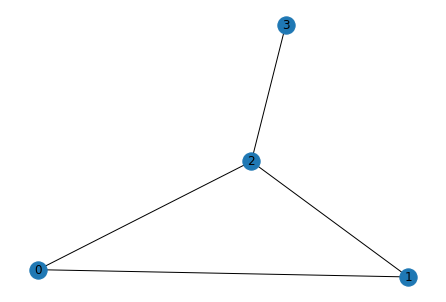

In [13]:
import networkx as nx 
from scipy.special import binom

A  = np.array(
    [[0, 1, 1, 0],
     [1, 0, 1, 0],
     [1, 1, 0, 1],
     [0, 0, 1, 0]]
)

G = nx.from_numpy_array(A)
nx.draw(G,with_labels=True)

def nth(A, n):
    A_ = A.copy()    
    for _ in range(1,n):
        A = A.dot(A_)
    return A

a_t = nth(A,3).diagonal().sum()/6
n = len(A[:,0])
p_t = binom(n, 3)

In [14]:
def make_net(el_, nodes):
    '''
    Convert edgelist to networkx graph which is 
    binary and undirected.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''    
    
    nx_input = el_, 'u1', 'u2', 'count', nx.Graph()
    g = nx.from_pandas_edgelist(*nx_input)
    g.add_nodes_from(nodes)
    return g

In [16]:
from scipy.special import binom

def fraction_triangles(el_, nodes):
    '''
    Compute fraction of actual triangles out 
    of the potential triangles.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''
    
    g = make_net(el_, nodes)
    
    #Q.1: what is `A`?: the adjacency matrix which is symmetric and binary        
    #Q.2: what does `A**3` do? compute the number of paths between two nodes    
    #Q.3: what is diagonal of A_t? the number of actual paths of length 3, 
    # i.e. triangles, which include the person. these are called cycles
    # because they start and end at the same person
    
    # count actual triangles    
    A = nx.to_scipy_sparse_matrix(g)
    A_t = A**3
    a_t = A_t.diagonal().sum()/6
    
    #Q.4: what does `binom(n,3)` compute? the number of triangles including the person
    
    # count potential triangles
    n = len(g.nodes())
    p_t = binom(n, 3)
        
    return a_t/p_t

> **Ex. 13.1.4**: Apply the function `fraction_triangles` to `el_agg` and print the triangle fraction in the network. Next remove all edges that go between classes. Compute triangle fraction within each class and store it. Compute the mean within class triangles and bootstrap the standard error of the mean. Comment on the output.
>
>> *Hint:* To bootstrap an estimate draw $k>>0$ samples with replacement from the data. Compute the estimate on each of these samples and average them in the end to get the bootstrapped estimate. 

In [73]:
#applying fraction_triangles to el_agg
frac_tri_total= fraction_triangles(el_agg, el_agg['u1'])

# making coloumn identifing different classes. 

el_agg['same_class'] = el_agg['class_x'] == el_agg['class_y']
el_agg.head()

print(f'the total fraction_triangles for el_agg is {frac_tri_total}')

the total fraction_triangles for el_agg is 0.005962397231915774


In [75]:
#remove all observations where u1 and u2 are meeting in different classes
el_agg = el_agg[el_agg['same_class'] == True]
el_agg= el_agg.drop('class_y', axis = 'columns')

#rename columns
el_agg = el_agg.rename(columns = {'class_x': 'class', 'gender_x' : 'gender_u1', 'gender_y': 'gender_u2'})

In [76]:
class_values = {}

for class_name in el_agg['class'].unique():
    df = el_agg.loc[el_agg['class'] == class_name]
    nodes = df['u1']
    
    # update dict
    class_values.update( {'{}'.format(class_name) : fraction_triangles(df,nodes)})

class_values_df = pd.DataFrame([class_values])
class_values_df = pd.Series(class_values)
class_values

{'2BIO3': 0.4653846153846154,
 'MP': 0.5071154898741106,
 'MP*2': 0.3794452347083926,
 '2BIO2': 0.40194281524926684,
 '2BIO1': 0.3176470588235294,
 'PC*': 0.4229086229086229,
 'PSI*': 0.2747326203208556,
 'PC': 0.44971307762005436,
 'MP*1': 0.17925561029009304}

In [77]:
def bootstrap(df, n = 100 ,frac = 1/3):
        l = []
        for i in range(n):
            mean = l.append(df.sample(frac = frac))
        mean, std = np.mean(l), np.std(l)
        return mean, std 


bs_mean, bs_std = bootstrap(df = class_values_df, n = 1000)

print(f'The boostrapped mean: {bs_mean}')
print(f'The bootstrapped standard deviation: {bs_std}')

The boostrapped mean: 0.37811295946270335
The bootstrapped standard deviation: 0.09754713631037142


Recall from class that we can define the following measures of homophily. We define **homophily index** inspired by [Currarini et al. (2009)](https://doi.org/10.2139/ssrn.1021650):
- share of edges that are same type: $H = \frac{s}{s+d}$
- possible range [0,1]


We define **baseline homophily** as: 
- We count fraction of potential edges in population of nodes which are same type:

\begin{equation}B=\frac{\sum_t\#potential(n_t)}{\#potential(n)}, \qquad \#potential(k)=\frac{k\cdot(k-1)}{2}\end{equation}

- Interpretation: Expected homophily from random link formation.     

We define **inbreeding homophily** as:      

\begin{equation}IH=\frac{H-B}{1-B}\end{equation}


> **Ex. 13.1.5**: Compute the inbreeding homophily for each class. Use the class measures to compute the mean. Use a bootstrap to compute whether there is inbreeding homophily.

> **Ex. 13.1.6** (BONUS): Describe what an unsupported edge is. Construct a test of whether there is a preference for forming  triangles within same gender than across.
>
>> *Hint:*  You can find inspiration in the approach of [Chandrasekhar, Jackson (2018)](https://web.stanford.edu/~arungc/CJ_sugm.pdf) pp. 31-35. They construct an almost identical test for triangle formation across castes in Indian villages.

In [ ]:
# [Answer to ex. 13.1.6 here]